# Neonate Weight Classification - Feature Selection Using Linear SVC

In [1]:
import pandas as pd
import numpy as np

In [2]:
weightDf = pd.read_csv('C:/Users/Nefeli/Desktop/biomed_project_data/weightDf_bin.csv')

In [3]:
#to_drop=['FHR_I_ffill_haar_shan_entr','FHR_II_ffill_haar_shan_entr']
#weightDf= weightDf.drop(columns=to_drop).copy()

#Prep dataframe
weightDf.replace([np.inf, -np.inf], np.nan, inplace=True)
weightDf.dropna(inplace=True)
weightDf = weightDf.reset_index(drop=True)
weightDf.shape

(221, 53)

In [4]:
target = ['Neonate_Weight']
X = weightDf.drop(target, axis=1).copy()
y =weightDf[target].copy()

In [5]:
y_labels, counts = np.unique(y['Neonate_Weight'], return_counts=True)
print(y_labels)
print(counts)

['ABNORM' 'NORM']
[ 19 202]


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y['Neonate_Weight'].ravel())
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping:")
print(label_mapping)

Mapping:
{'ABNORM': 0, 'NORM': 1}


#### Feature Selection with LinearSVC and SelectFromModel 

In [7]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False,max_iter=100000).fit(X, y['Neonate_Weight'].ravel())
model = SelectFromModel(lsvc, prefit=True)
X_red = model.transform(X)
X_red.shape

C:\Users\Nefeli\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Nefeli\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(221, 5)

In [8]:
# Set feature names explicitly
X_red_named = pd.DataFrame(X_red, columns=X.columns[model.get_support()])

# Print the shape of the transformed data
print("Shape of transformed X:", X_red_named.shape)
X_red_named.columns

Shape of transformed X: (221, 5)


Index(['FHR_I_ffill_mean_nni', 'FHR_I_ffill_total_power', 'FHR_II_ffill_nni20',
       'FHR_II_ffill_total_power', 'diff_nni20'],
      dtype='object')

### Imports For Models:

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap 
import xgboost
import matplotlib.pylab as plt

### K-NN

#### Train and Fit

In [10]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_red_named, y_encoded.ravel(), test_size=0.2, random_state=42)

num_nb = 20 # num of neighbors

#train and fit 
knn_clf = KNeighborsClassifier(n_neighbors=num_nb)
fitted_knn=knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

# get accruacy
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_report_str}')


Accuracy: 0.8444444444444444
Confusion Matrix:
[[ 0  7]
 [ 0 38]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.84      1.00      0.92        38

    accuracy                           0.84        45
   macro avg       0.42      0.50      0.46        45
weighted avg       0.71      0.84      0.77        45



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


#### ROC 

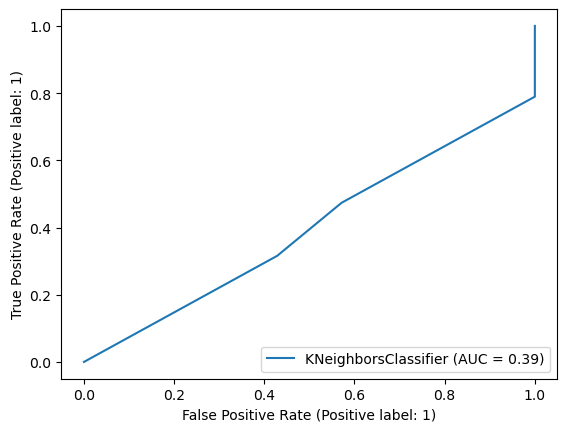

In [11]:
knn_disp = RocCurveDisplay.from_estimator(fitted_knn , X_test, y_test)
plt.show()

#### K-fold Cross Validation for K = 5

In [12]:
cross_val_scores_acc = cross_val_score(knn_clf, X_red_named, y_encoded, scoring= 'accuracy')
print("Accuracy for all folds: ", cross_val_scores_acc)
print("Mean Accuracy: ", cross_val_scores_acc.mean())

cross_val_scores_f1 = cross_val_score(knn_clf, X_red_named, y_encoded, scoring= 'f1')
print("F1 Score for all folds: ", cross_val_scores_f1)
print("Mean F1 Score: ", cross_val_scores_f1.mean())


cross_val_scores_pr = cross_val_score(knn_clf, X_red_named, y_encoded, scoring= 'precision')
print("Precision for all folds: ", cross_val_scores_pr)
print("Mean Precision: ", cross_val_scores_pr.mean())


cross_val_scores_r = cross_val_score(knn_clf, X_red_named, y_encoded, scoring= 'recall')
print("Recall for all folds: ", cross_val_scores_pr)
print("Mean Recall: ", cross_val_scores_pr.mean())

Accuracy for all folds:  [0.91111111 0.93181818 0.90909091 0.90909091 0.90909091]
Mean Accuracy:  0.914040404040404
F1 Score for all folds:  [0.95348837 0.96470588 0.95238095 0.95238095 0.95238095]
Mean F1 Score:  0.9550674223177644
Precision for all folds:  [0.91111111 0.93181818 0.90909091 0.90909091 0.90909091]
Mean Precision:  0.914040404040404
Recall for all folds:  [0.91111111 0.93181818 0.90909091 0.90909091 0.90909091]
Mean Recall:  0.914040404040404


### Random Forest Classifier

#### Train and Fit 

In [13]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_red_named, y_encoded.ravel(), test_size=0.2, random_state=42)

#train and fit
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
fitted_rf = rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

# get accuracy and metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)


print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_report_str}')


Accuracy: 0.8444444444444444
Confusion Matrix:
[[ 0  7]
 [ 0 38]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.84      1.00      0.92        38

    accuracy                           0.84        45
   macro avg       0.42      0.50      0.46        45
weighted avg       0.71      0.84      0.77        45



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


#### ROC

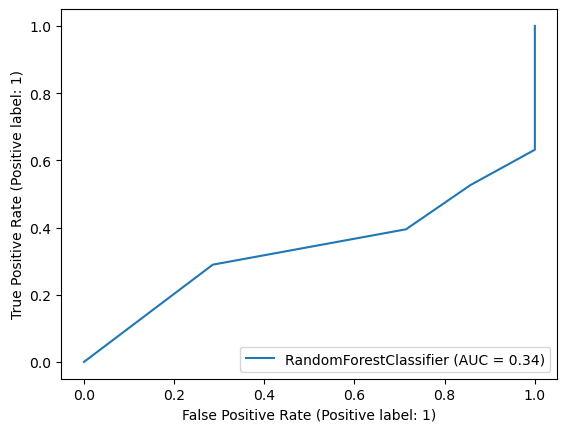

In [14]:
rf_disp = RocCurveDisplay.from_estimator(fitted_rf , X_test, y_test)
plt.show()

#### K-fold Cross Validation for K = 5

In [15]:
cross_val_scores_acc = cross_val_score(rf_clf, X_red_named, y_encoded,  scoring= 'accuracy')
print("Accuracy for all folds: ", cross_val_scores_acc)
print("Mean Accuracy: ", cross_val_scores_acc.mean())

cross_val_scores_f1 = cross_val_score(rf_clf, X_red_named, y_encoded,  scoring= 'f1')
print("F1 Score for all folds: ", cross_val_scores_f1)
print("Mean F1 Score: ", cross_val_scores_f1.mean())


cross_val_scores_pr = cross_val_score(rf_clf, X_red_named, y_encoded, scoring= 'precision')
print("Precision for all folds: ", cross_val_scores_pr)
print("Mean Precision: ", cross_val_scores_pr.mean())


cross_val_scores_r = cross_val_score(rf_clf, X_red_named, y_encoded,  scoring= 'recall')
print("Recall for all folds: ", cross_val_scores_pr)
print("Mean Recall: ", cross_val_scores_pr.mean())

Accuracy for all folds:  [0.88888889 0.93181818 0.90909091 0.90909091 0.90909091]
Mean Accuracy:  0.9095959595959595
F1 Score for all folds:  [0.94117647 0.96470588 0.95238095 0.95238095 0.95238095]
Mean F1 Score:  0.9526050420168067
Precision for all folds:  [0.90909091 0.93181818 0.90909091 0.90909091 0.90909091]
Mean Precision:  0.9136363636363637
Recall for all folds:  [0.90909091 0.93181818 0.90909091 0.90909091 0.90909091]
Mean Recall:  0.9136363636363637


## XGBoost Classifier 

#### Train and Fit 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_red_named, y_encoded, test_size=0.2, random_state=42)
xg_clf = xgboost.XGBClassifier()
fitted_xg = xg_clf.fit(X_train, y_train)
y_pred = xg_clf.predict(X_test)

# get accuracy and metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)


print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_report_str}')

Accuracy: 0.8444444444444444
Confusion Matrix:
[[ 0  7]
 [ 0 38]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.84      1.00      0.92        38

    accuracy                           0.84        45
   macro avg       0.42      0.50      0.46        45
weighted avg       0.71      0.84      0.77        45



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


#### ROC 

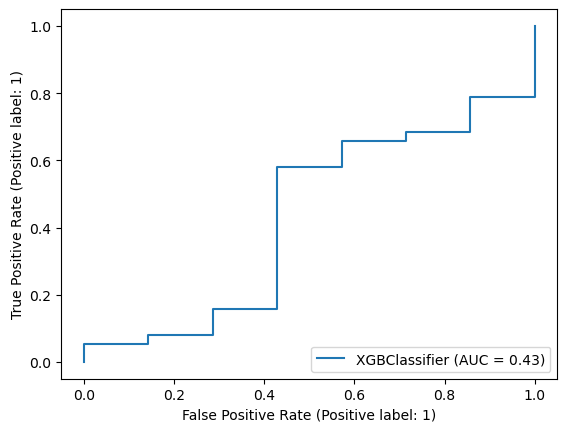

In [17]:
rf_disp = RocCurveDisplay.from_estimator(fitted_xg , X_test, y_test)
plt.show()

#### K-fold Cross Validation for K = 5

In [18]:
cross_val_scores_acc = cross_val_score(xg_clf, X_red_named, y_encoded,  scoring= 'accuracy')
print("Accuracy for all folds: ", cross_val_scores_acc)
print("Mean Accuracy: ", cross_val_scores_acc.mean())

cross_val_scores_f1 = cross_val_score(xg_clf, X_red_named, y_encoded,  scoring= 'f1')
print("F1 Score for all folds: ", cross_val_scores_f1)
print("Mean F1 Score: ", cross_val_scores_f1.mean())


cross_val_scores_pr = cross_val_score(xg_clf, X_red_named, y_encoded,  scoring= 'precision')
print("Precision for all folds: ", cross_val_scores_pr)
print("Mean Precision: ", cross_val_scores_pr.mean())


cross_val_scores_r = cross_val_score(xg_clf, X_red_named, y_encoded,  scoring= 'recall')
print("Recall for all folds: ", cross_val_scores_pr)
print("Mean Recall: ", cross_val_scores_pr.mean())

Accuracy for all folds:  [0.86666667 0.90909091 0.86363636 0.90909091 0.84090909]
Mean Accuracy:  0.8778787878787879
F1 Score for all folds:  [0.92857143 0.95238095 0.92682927 0.95238095 0.91358025]
Mean F1 Score:  0.9347485697079192
Precision for all folds:  [0.90697674 0.93023256 0.9047619  0.90909091 0.90243902]
Mean Precision:  0.9107002281137279
Recall for all folds:  [0.90697674 0.93023256 0.9047619  0.90909091 0.90243902]
Mean Recall:  0.9107002281137279


### Exploring Feature Importance in the XGBoost Classifier implementation using the SHAP library 

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html

<Figure size 10000x480 with 0 Axes>

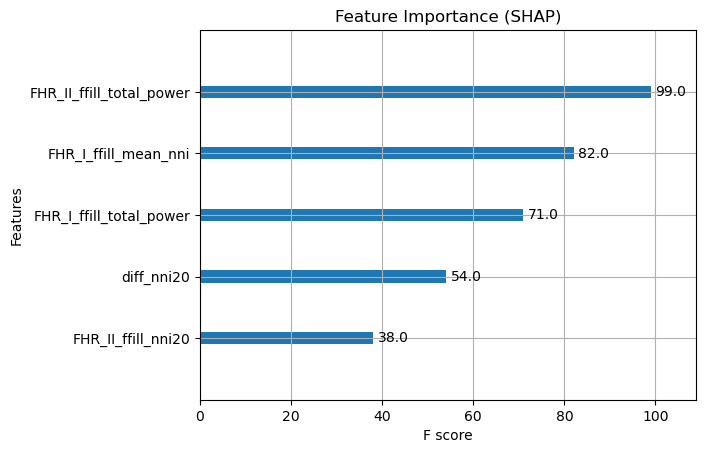

In [19]:
plt.figure().set_figwidth(100)
xgboost.plot_importance(xg_clf)

plt.title("Feature Importance (SHAP)")
plt.show()


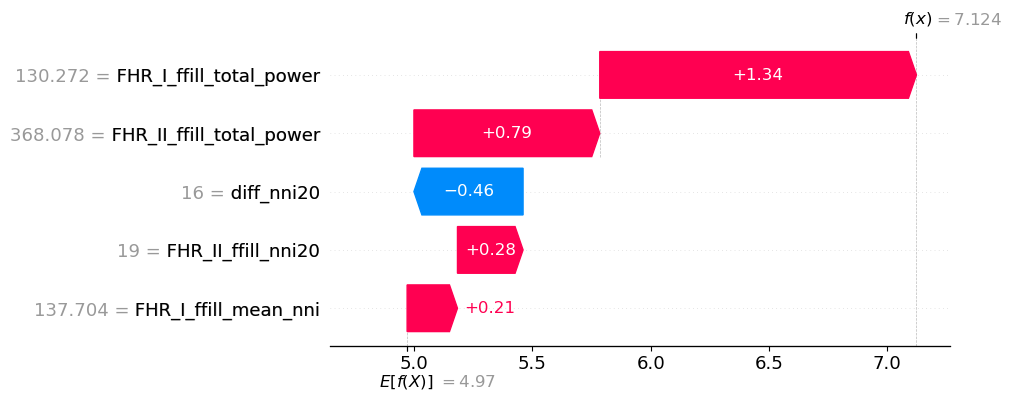

In [20]:
explainer = shap.Explainer(xg_clf, X_red_named)
shap_values = explainer(X_red_named)
shap.plots.waterfall(shap_values[0])